# Particle MCMC model for COVID-19 in Mexico

This notebook contains all of the Python code needed to use Particle Marginal Markov Chain Monte Carlo to explore the parameter space of our diffusion driven model and estimate the trajectories of the hidden states

In [1]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
import math

In [2]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.head()

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0


In [3]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))


Total Population:  126014024
0.01% of Population:  126014


Below we create two functions to draw from our prior distributions for initial value conditions and model parameters

In [4]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, np.round(0.0001 * N).astype(int)).rvs(num_particles)   #stats.uniform(0, 100).rvs(num_particles)
    U = stats.uniform(0, np.round(0.0001 * N).astype(int)).rvs(num_particles)           #stats.uniform(0,5).rvs(num_particles)
    O = np.ones(num_particles) * 4 
    E = E - U - O    
    S = N - E - U 
    
    beta = stats.uniform(0,10).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(10,scale=100).rvs()
    psi_d = stats.gamma(10,scale=100).rvs() 
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]
    

We begin by defining the SEUORDS model and understanding if the model will be able to produce results similar to those seen during the COVID-19 pandemic in Mexico

In [5]:
def BM_SEUORDS(X_in, params, num_particles, m):
    num_steps = m + 1  # Initial step + m observations + final step
    h = 1 / num_steps  # Adjust step size

    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles, num_steps + 1])
    Z1 = np.zeros([num_particles, num_steps + 1])
    Z2 = np.zeros([num_particles, num_steps + 1])
    
    new_undetected = np.zeros([num_particles])
    new_observed = np.zeros([num_particles])
    new_deaths = np.zeros([num_particles])

    # Set initial conditions
    alpha, rho, nu, gamma, sigma_b, sigma_m, _, _ = params
    X[:, :, 0] = X_in
    Z1[:, 0] = np.log(X_in[6, :])  # Logit for beta(0)
    Z2[:, 0] = np.log(X_in[7, :])  # Logit for mu(0)

    # Simulate the SIR model with stochastic beta using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Sample Brownian increment
        dB1 = stats.norm(0, 1).rvs(num_particles)
        dB2 = stats.norm(0, 1).rvs(num_particles)
        
        # Update Z using Euler-Maruyama method
        Z1[:, t] = Z1[:, t - 1] + sigma_b * dB1 * np.sqrt(h)
        Z2[:, t] = Z2[:, t - 1] + sigma_m * dB2 * np.sqrt(h)
        
        # Update time-varying parameter values
        X[6, :, t] = np.exp(Z1[:, t]) # beta(t)
        X[7, :, t] = np.exp(Z2[:, t]) # mu(t)
        
        # Update SEUORDS model
        X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
        X[1, :, t] = X[1, :, t - 1] + (X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
        X[2, :, t] = X[2, :, t - 1] + (rho * nu * X[1, :, t - 1] - gamma * X[2, :, t - 1]) * h                                                  # U-Unobserved
        X[3, :, t] = X[3, :, t - 1] + ((1 - rho) * nu * X[1, :, t - 1] - gamma * X[3, :, t - 1] - X[7, :, t-1] * X[3, :, t - 1]) * h            # O-Observed
        X[4, :, t] = X[4, :, t - 1] + (gamma * (X[2, :, t - 1] + X[3, :, t - 1]) - alpha * X[4, :, t - 1]) * h                                  # R-Recovered
        X[5, :, t] = X[5, :, t - 1] + (X[7, :, t-1] * X[3, :, t - 1]) * h                                                                       # D-Death
        
        new_undetected += (rho * nu * X[1, :, t - 1]) * h
        new_observed += ((1 - rho) * nu * X[1, :, t - 1]) * h
        new_deaths += (X[7, :, t] * X[3, :, t - 1]) * h   
    
    return X, new_observed, new_deaths, new_undetected

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:35: RuntimeWarning: overflow encountered in multiply
  X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:36: RuntimeWarning: overflow encountered in multiply
  X[1, :, t] = X[1, :, t - 1] + (X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:35: RuntimeWarning: invalid value encountered in add
  X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:36: RuntimeWarning: invalid value encountered in add
  X[1, :, t] = X

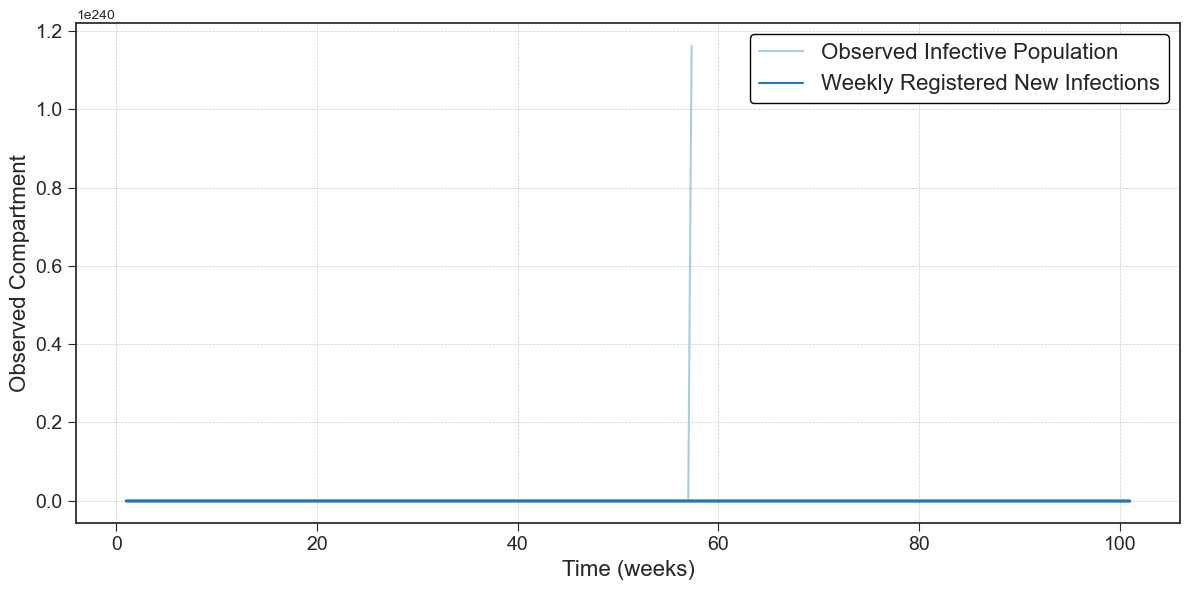

In [6]:
# Define the number of periods and steps per period
T = 100 # Number of periods 
m = 2  # Number of observations per period (intermediate steps)
num_steps = m + 1  # Number of time steps per period including the initial step
total_steps = T * num_steps  # Total number of time steps across all periods
num_particles = 20  # Number of particles

# Set initial conditions
params = set_param_priors()
initial_states = set_IVC(N, num_particles)

# Initialize the arrays to store results
states = np.zeros([initial_states.shape[0], num_particles, total_steps + 1])  # Includes the initial step
states[:, :, 0] = initial_states  
aggregates = np.zeros([3, num_particles, T + 1])  
start_idx = 0  

# Run the model over T periods with weekly aggregation
for t in range(1, T + 1):
    end_idx = start_idx + m + 1 
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(states[:, :, start_idx], params, num_particles, m)
    # Store the generated states and aggregate counts for this period
    states[:, :, start_idx + 1:end_idx+1] = weekly_results[:, :, 1:]
    aggregates[:, :, t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Update the start index for the next period
    start_idx = end_idx


# Plot the simulation for each particle
time = np.linspace(1, T+1, total_steps+1 )

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, states[3, 0, :], color=colors[0], label='Observed Infective Population')
plt.plot(np.arange(1,T+2), aggregates[0, 0, :], color=colors[1], label='Weekly Registered New Infections')
    
for p in range(1,num_particles):
    plt.plot(time, states[3, p, :], color=colors[0])
    plt.plot(np.arange(1,T+2), aggregates[0, p, :], color=colors[1])

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Observed Compartment', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

We now define our negative binomial function to run our bootstrap particle filter

In [7]:
# Create NB log-likelihood function
def NB_log_likelihood(y, mu, psi):
    # Add a small positive constant to avoid numerical instability
    mu = np.maximum(mu, 1e-10)
    psi = np.maximum(psi, 1e-10)
    aux = mu + psi
    
    return gammaln(y + psi) - gammaln(y+1) - gammaln(psi) + y * (np.log(mu) - np.log(aux)) + psi * (np.log(psi) - np.log(aux))

Following the steps of Dahlin, J. and Schön, T. B.$^1$ we work with the shifted log weights to avoid problems with numerical precision where we define
$$
v^{(i)}_t = \log(w^{(i)}_t) - v_{max}
$$
with $v_{max} = \max_{i} \log(w^{(i)}_t)$ and $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$. 

With this in mind, the normalized weights can be calculated using 
$$ 
\bar{w}^{(i)}_t = \frac{w^{(i)}_t}{\sum_i w^{(i)}_t} = \frac{e^{v_{max}} e^{v^{(i)}_t}}{\sum_i e^{v_{max}} e^{v^{(i)}_t}} = \frac{e^{v^{(i)}_t}}{\sum_i e^{v^{(i)}_t}} = \tilde{v}^{(i)}_t.
$$

Additionally, instead of calculating the marginal likelihood
$$
\hat{p}(y_{1:t}) = \hat{p}(y_{1:t-1}) \hat{p}(y_t | y_{1:t-1}) = \hat{p}(y_{1:t-1}) \left( \frac{1}{N} \sum_i w^{(i)}_t \right)
$$
we can approximate the marginal log-likelihood using $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$ with
\begin{align*}
\log (\hat{p}(y_{1:t})) & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i w^{(i)}_t \right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i e^{v_{max}} e^{v^{(i)}_t}\right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log(v_{max}) + \log\left( \sum_i e^{v^{(i)}_t} \right) - \log(N)
\end{align*}

$1$: Dahlin, J., & Schön, T. B. (2019). *Getting started with particle Metropolis-Hastings for inference in nonlinear dynamical models*. Journal of Statistical Software, 88, 1–41.


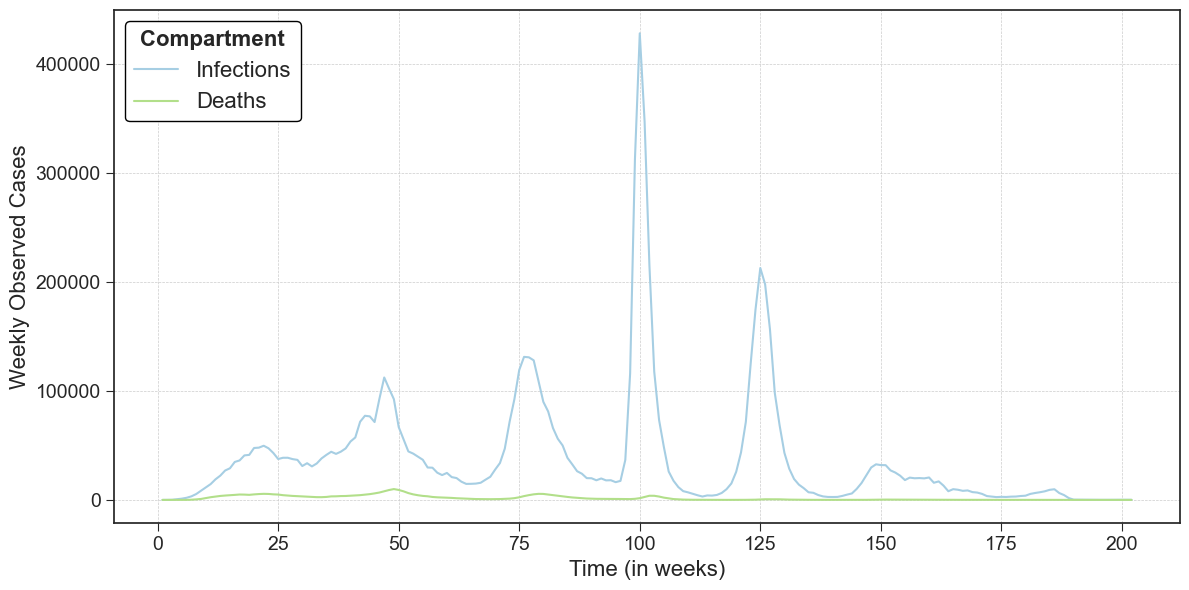

In [8]:
# Define subset of data to run the algorithm 
weeks = 202

YO = weekly_covid_df['confirmed_cases'].values[:weeks]
YD = weekly_covid_df['confirmed_deaths'].values[:weeks]

time = np.linspace(1, weeks, weeks)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, YO, color=colors[0], label='Infections')
plt.plot(time, YD, color=colors[2], label='Deaths')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [9]:
T =  weeks - 1
m = 10
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 5000

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

# Initialize PF variables
state_estimates = np.zeros([3, T+1])
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
resampled_partices = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([3, num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
original_particles = particles.copy()
weekly_aggregates[0,:,0] = particles[3, :, 0]
weekly_aggregates[1,:,0] = particles[5, :, 0]
weekly_aggregates[2,:,0] = particles[2, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_aggregates[0,:,0], params[6]) + NB_log_likelihood(YD[0], weekly_aggregates[1,:,0], params[7]) 
max_weights = np.max(incremental_weights)
weights[:,0] = np.exp(incremental_weights - max_weights)
sum_weights = weights[:,0].sum()
norm_weights[:,0] = weights[:,0] / sum_weights
    
ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))
loglikelihood += max_weights + np.log(np.sum(weights[:,0])) - np.log(num_particles)
state_estimates[:,0] = np.sum(weekly_aggregates[:,:,0]*norm_weights[:,0], axis=1)

if ESS[0] <= num_particles:
    # Systematic resampling at time t=0
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
        
    ancestry_matrix[:,0] = resample_indices
else:
    ancestry_matrix[:,0] = np.arange(num_particles)
    
start_idx = 0
for t in range(1,T+1):
    # Propagate particles to next week
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), start_idx], params, num_particles, m)
    weekly_aggregates[:,:,t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Store updated particle values
    end_idx = start_idx + num_steps    
    particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    original_particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    
    # Update particle weights and resample
    incremental_weights = NB_log_likelihood(YO[t], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t], weekly_aggregates[1,:,t], params[7]) 
    #incremental_weights = NB_log_likelihood(YO[t], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t], weekly_aggregates[1,:,t], params[7]) 
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    if np.isnan(loglikelihood):
        break
    state_estimates[:,t] = np.sum(weekly_aggregates[:,:,t]*norm_weights[:,t], axis=1)
    
    if ESS[t] <= num_particles:
        # Systematic resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
        
        ancestry_matrix[:,t] = resample_indices
        #particles[:, :, :end_idx+1] = particles[:, resample_indices.astype(int), :end_idx +1]
        #weekly_aggregates[:, :, :t] = weekly_aggregates[:, resample_indices.astype(int), :t]
    else:
        ancestry_matrix[:,t] = np.arange(num_particles)
        
    start_idx = end_idx
    
print(loglikelihood)

-129518.5372096163


Text(0.5, 1.0, 'ESS')

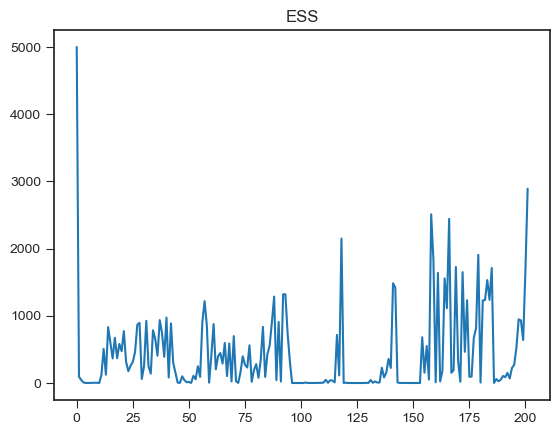

In [10]:
plt.plot(ESS)
plt.title('ESS')

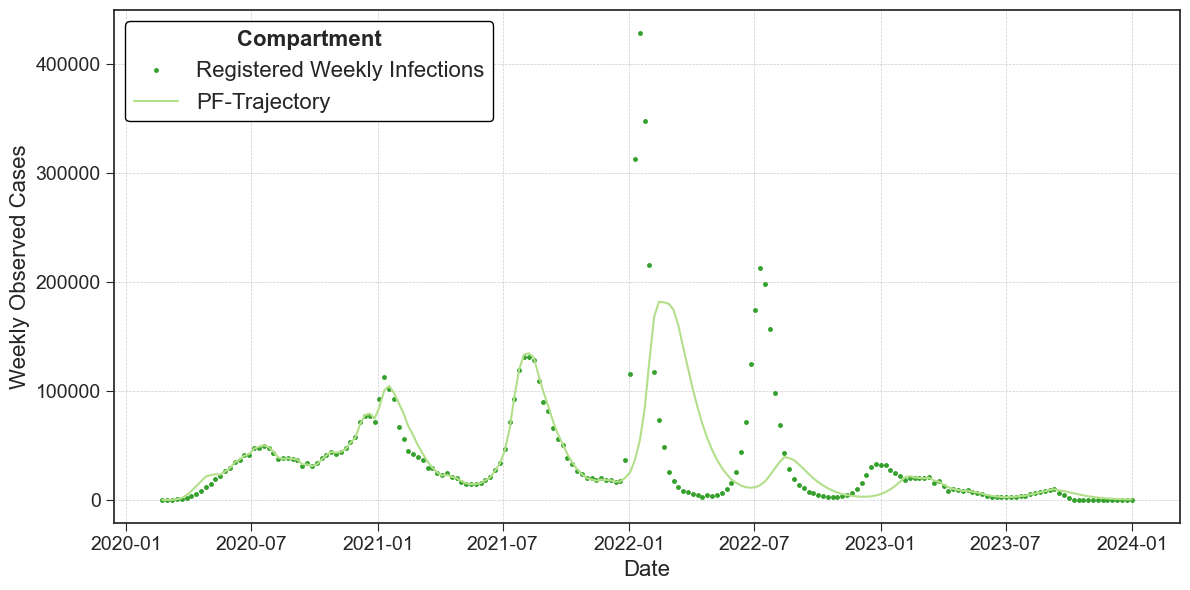

In [11]:
time = np.linspace(1,T+1,T+1)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(weekly_covid_df['date'][:T+1], YO, marker='o', linewidth=0, markersize=2.5, color=colors[3], label='Registered Weekly Infections')
plt.plot(weekly_covid_df['date'][:T+1], state_estimates[0,:], color=colors[2], label='PF-Trajectory')


plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

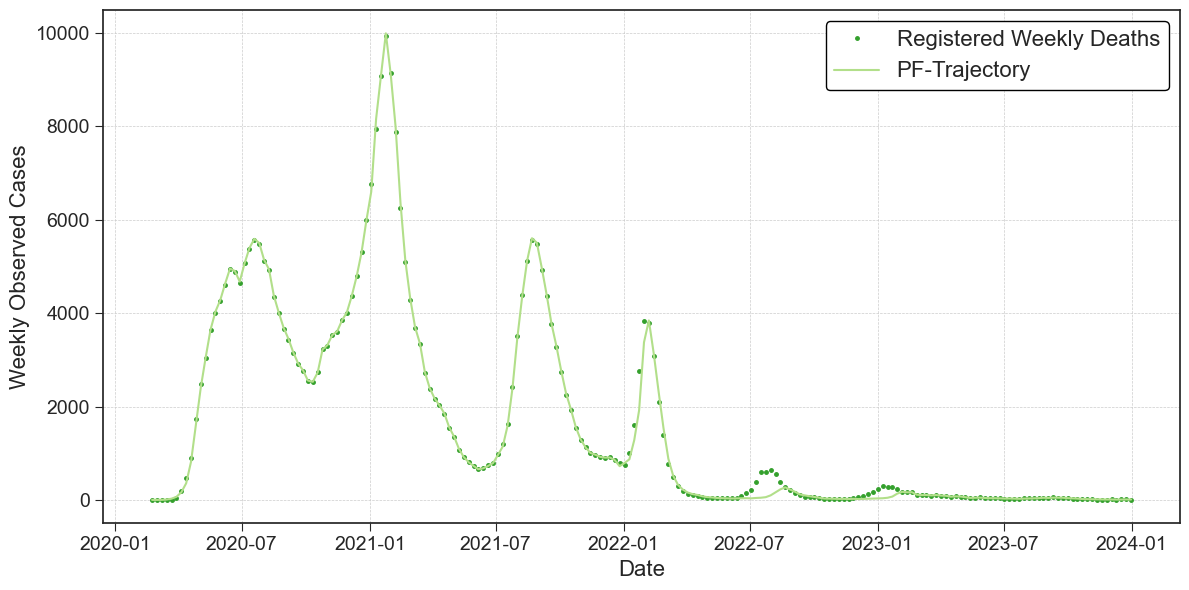

In [12]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(weekly_covid_df['date'][:T+1], YD, marker='o', linewidth=0, markersize=2.5, color=colors[3], label='Registered Weekly Deaths')
plt.plot(weekly_covid_df['date'][:T+1], state_estimates[1,:], color=colors[2], label='PF-Trajectory')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

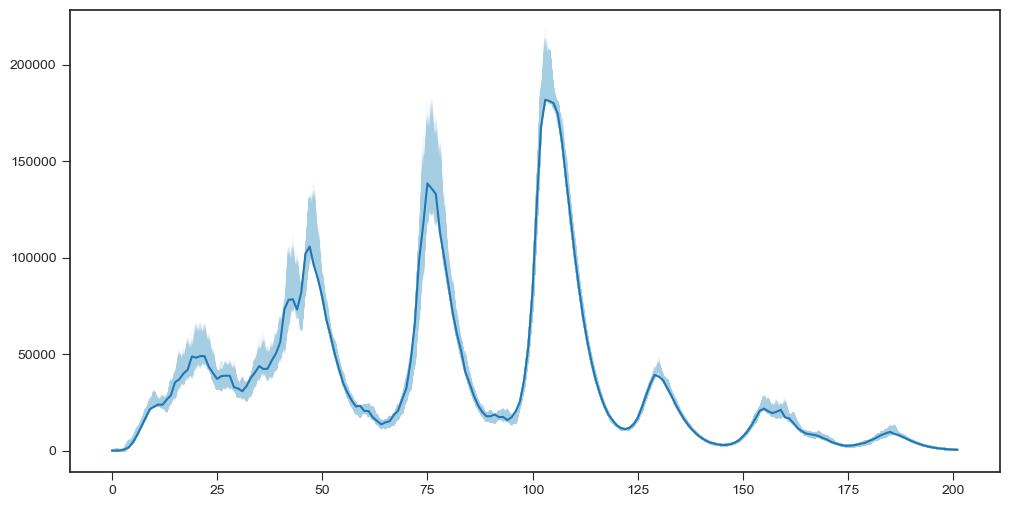

In [13]:
chosen_particle = np.random.choice(np.arange(num_particles))#, p=norm_weights[:, T])
chosen_ancestry_indices = ancestry_matrix[chosen_particle, :].astype(int)
sampled_path = weekly_aggregates[:, chosen_ancestry_indices, np.arange(T + 1)]
plt.figure(figsize=(12,6))
for p in range(num_particles):
    plt.plot(weekly_aggregates[0,p,:], color=colors[0], alpha=0.1)
plt.plot(sampled_path[0,:], color=colors[1])
plt.show()

3829


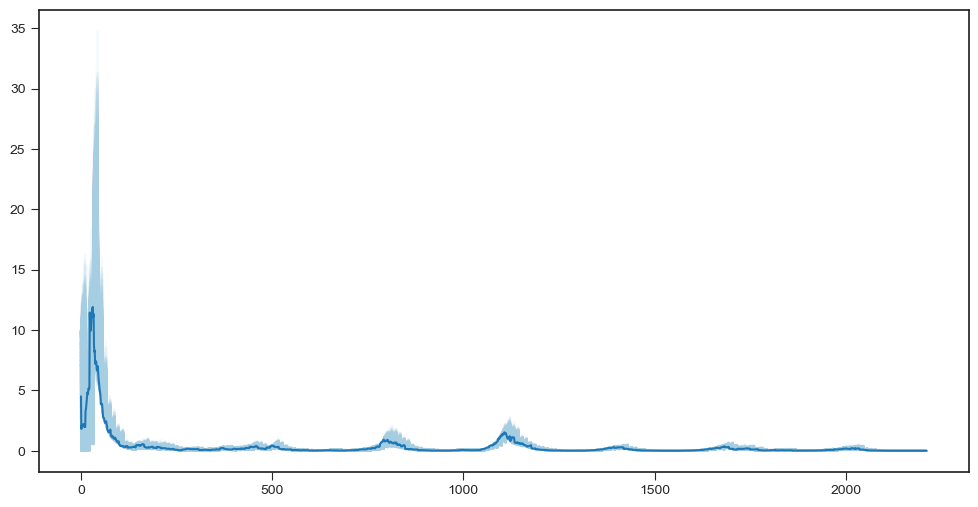

In [14]:
# Reshape the first column to be 2D so it can be stacked
first_column = np.expand_dims(ancestry_matrix[:, 0], axis=1)

# Repeat each column in ancestry_matrix[:, 1:] m+1 times
repeated_columns = np.repeat(ancestry_matrix[:, 1:], m+1, axis=1)

# Concatenate the first column with the repeated columns
expanded_ancestry_matrix = np.hstack((first_column, repeated_columns))

# Step 1: Select a particle index at the final time step
final_weights = norm_weights[:, T]
chosen_particle = np.random.choice(np.arange(num_particles), p=final_weights)
print(chosen_particle)

# Step 2: Retrieve the full ancestry lineage using the chosen particle's row in expanded_ancestry_matrix
# This will give you the indices over time for the chosen particle's ancestry
chosen_ancestry_indices = expanded_ancestry_matrix[chosen_particle, :].astype(int)

# Step 3: Use these indices to sample the trajectory from particles
sampled_path = particles[:, chosen_ancestry_indices, np.arange(total_steps + 1)]

plt.figure(figsize=(12,6))
for p in range(num_particles):
    plt.plot(particles[6,p,:], color=colors[0], alpha=0.1)
plt.plot(sampled_path[6,:], color=colors[1])
plt.show()

Below we optimize our Bootstrap Particle Filter for its use within our PFMCMC algorithm

In [15]:
T =  weeks - 1
m = 21
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 1000

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([3, num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_aggregates[0,:,0] = particles[3, :, 0]
weekly_aggregates[1,:,0] = particles[5, :, 0]
weekly_aggregates[2,:,0] = particles[2, :, 0]

# Calculate separate log-likelihoods for infections and deaths
infection_log_likelihood = NB_log_likelihood(YO[0], weekly_aggregates[0, :, 0], params[6])
death_log_likelihood = NB_log_likelihood(YD[0], weekly_aggregates[1, :, 0], params[7])

# Normalize each likelihood separately for numerical stability
max_infection_ll = np.max(infection_log_likelihood)
infection_weights = np.exp(infection_log_likelihood - max_infection_ll)
loglikelihood += max_infection_ll + np.log(np.sum(infection_weights)) - np.log(num_particles)
infection_weights = infection_weights / infection_weights.sum()

max_death_ll = np.max(death_log_likelihood)
death_weights = np.exp(death_log_likelihood - max_death_ll)
loglikelihood +=  max_death_ll + np.log(np.sum(death_weights)) - np.log(num_particles)
death_weights = death_weights / death_weights.sum()

# Combine normalized weights, averaging or taking a weighted product if desired
combined_weights = infection_weights * death_weights
combined_weights /= combined_weights.sum()  # Normalize combined weights
norm_weights[:, 0] = combined_weights
ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))

if ESS[0] <= 0.5*num_particles:
    # Systematic resampling at time t=0
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    ancestry_matrix[:,0] = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
else:
    ancestry_matrix[:,0] = np.arange(num_particles)
    
start_idx = 0
for t in range(1,T+1):
    # Propagate particles to next week
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), start_idx], params, num_particles, m)
    weekly_aggregates[:,:,t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Store updated particle values
    end_idx = start_idx + num_steps    
    particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    
    # Update particle weights
    infection_log_likelihood = NB_log_likelihood(YO[t], weekly_aggregates[0, :, t], params[6])
    death_log_likelihood = NB_log_likelihood(YD[t], weekly_aggregates[1, :, t], params[7])

    # Normalize each likelihood separately for numerical stability
    max_infection_ll = np.max(infection_log_likelihood)
    infection_weights = np.exp(infection_log_likelihood - max_infection_ll)
    loglikelihood += max_infection_ll + np.log(np.sum(infection_weights)) - np.log(num_particles)
    infection_weights = infection_weights / infection_weights.sum()

    max_death_ll = np.max(death_log_likelihood)
    death_weights = np.exp(death_log_likelihood - max_death_ll)
    loglikelihood +=  max_death_ll + np.log(np.sum(death_weights)) - np.log(num_particles)
    death_weights = death_weights / death_weights.sum()
    
    if np.isnan(loglikelihood):
        loglikelihood = np.inf
        break
    
    # Combine normalized weights
    combined_weights = infection_weights*death_weights
    combined_weights /= combined_weights.sum()  # Normalize combined weights

    # Update norm_weights for the current time step
    norm_weights[:, t] = combined_weights    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    
    if ESS[t] <= 0.5*num_particles:
        # Systematic resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        ancestry_matrix[:,t] = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
    else:
        ancestry_matrix[:,t] = np.arange(num_particles)
        
    start_idx = end_idx


# Return a sample trajectory of BPF results
chosen_particle = np.random.choice(np.arange(num_particles), p=norm_weights[:, T])
weekly_counts_trajectories = weekly_aggregates[:, ancestry_matrix[chosen_particle, :].astype(int), np.arange(T + 1)]

# Step 1: Reshape ancestry matrix to match discrete paths
first_column = np.expand_dims(ancestry_matrix[:, 0], axis=1)
repeated_columns = np.repeat(ancestry_matrix[:, 1:], m+1, axis=1) #ancestry does not change for each discrete run
expanded_ancestry_matrix = np.hstack((first_column, repeated_columns))

# Step 2: Retrieve the full ancestry lineage using the chosen particle's row in expanded_ancestry_matrix
parameter_trajectories = particles[6:, expanded_ancestry_matrix[chosen_particle, :].astype(int), np.arange(total_steps + 1)]

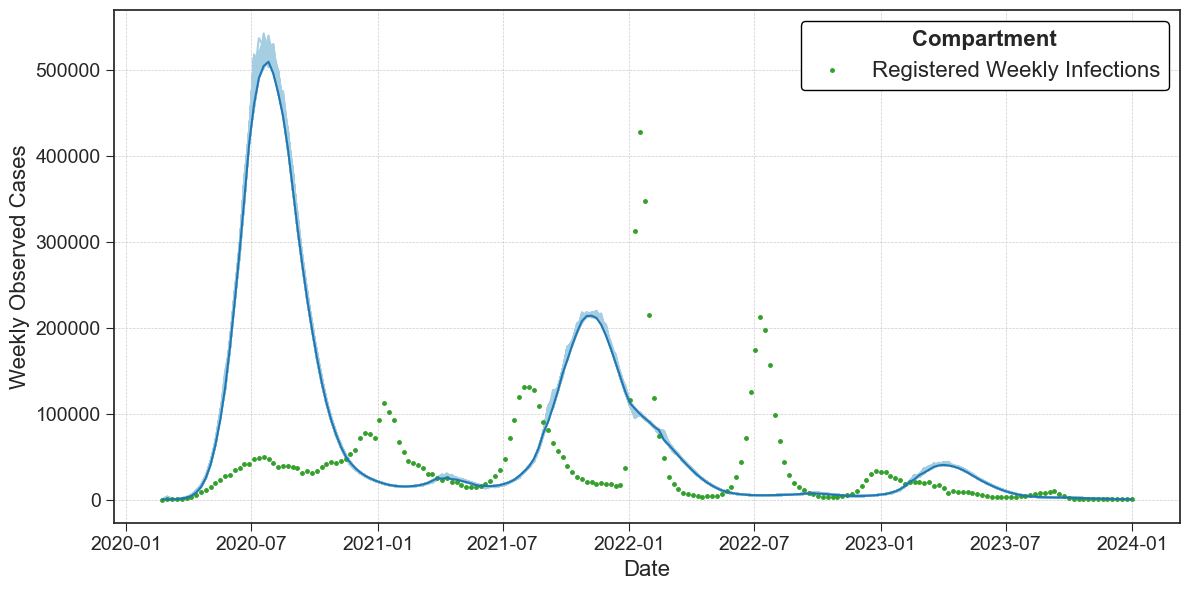

In [16]:
time = np.linspace(1,T+1,T+1)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(num_particles):
    plt.plot(weekly_covid_df['date'][:T+1], weekly_aggregates[0,p,:], color=colors[0])    
plt.plot(weekly_covid_df['date'][:T+1], YO, marker='o', linewidth=0, markersize=2.5, color=colors[3], label='Registered Weekly Infections')
plt.plot(weekly_covid_df['date'][:T+1], weekly_counts_trajectories[0,:], color=colors[1])
plt.legend(
    loc='upper right',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

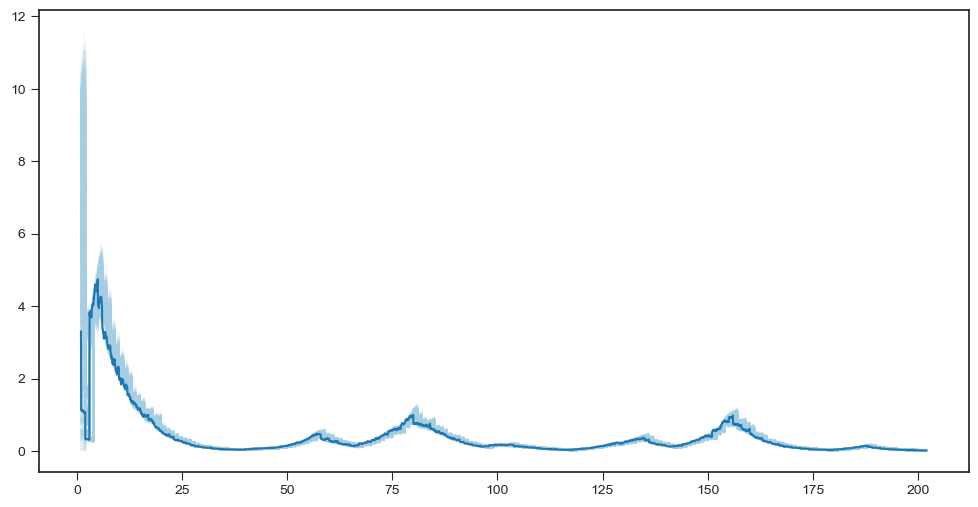

In [17]:
time = np.linspace(1,T+1,T*(m+1)+1)

plt.figure(figsize=(12,6))
for p in range(num_particles):
    plt.plot(time, particles[6,p,:], color=colors[0], alpha=0.1)
plt.plot(time, parameter_trajectories[0,:], color=colors[1])
plt.show()

In [18]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, np.round(0.0001 * N).astype(int)).rvs(num_particles)   #stats.uniform(0, 100).rvs(num_particles)
    U = stats.uniform(0, np.round(0.0001 * N).astype(int)).rvs(num_particles)           #stats.uniform(0,5).rvs(num_particles)
    O = np.ones(num_particles) * 4 
    E = E - U - O    
    S = N - E - U 
    
    beta = stats.uniform(0,10).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(10,scale=100).rvs()
    psi_d = stats.gamma(10,scale=100).rvs() 
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]

In [19]:
def particle_filter(YO, YD, N, T, m, num_particles, params, initial_conditions, BM_SEUORDS, NB_log_likelihood):
    # Derived parameters
    num_steps = m + 1
    total_steps = T * num_steps
    
    # Initialize PF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
    weekly_aggregates = np.zeros([3, num_particles, T + 1])
    norm_weights = np.zeros([num_particles, T + 1])
    ancestry_matrix = np.zeros([num_particles, T + 1], dtype=int)
    ESS = np.zeros(T + 1)
    loglikelihood = 0

    # Set initial conditions
    particles[:, :, 0] = initial_conditions
    weekly_aggregates[0, :, 0] = particles[3, :, 0]
    weekly_aggregates[1, :, 0] = particles[5, :, 0]
    weekly_aggregates[2, :, 0] = particles[2, :, 0]
    
    incremental_weights = NB_log_likelihood(YO[0], weekly_aggregates[0,:,0], params[6]) + NB_log_likelihood(YD[0], weekly_aggregates[1,:,0], params[7]) 
    max_weights = np.max(incremental_weights)
    weights = np.exp(incremental_weights - max_weights)
    sum_weights = weights.sum()
    norm_weights[:,0] = weights / sum_weights
    
    loglikelihood += max_weights + np.log(np.sum(weights)) - np.log(num_particles)
    ESS[0] = 1 / (np.sum(norm_weights[:, 0] ** 2))

    # Resampling at t=0 if needed
    positions = (np.arange(num_particles) + stats.uniform.rvs()) / num_particles
    ancestry_matrix[:, 0] = np.searchsorted(np.cumsum(norm_weights[:, 0]), positions)

    # Filtering through time steps
    start_idx = 0
    for t in range(1, T + 1):
        weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(
            particles[:, ancestry_matrix[:, t-1], start_idx], params, num_particles, m
        )
        weekly_aggregates[:, :, t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
        
        end_idx = start_idx + num_steps
        particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:]
        
        # Update particle weights and resample
        incremental_weights = NB_log_likelihood(YO[t], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t], weekly_aggregates[1,:,t], params[7]) 
        
        if np.isinf(incremental_weights).any():
            return -np.inf, None, None

        max_weights = np.max(incremental_weights)
        weights = np.exp(incremental_weights - max_weights)
        sum_weights = np.sum(weights)
        norm_weights[:,t] = weights/ sum_weights
                
        ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
        loglikelihood += max_weights + np.log(sum_weights) - np.log(num_particles)
        
        if np.isnan(loglikelihood):
            return -np.inf, None, None
    
        # Resampling if needed
        positions = (np.arange(num_particles) + stats.uniform(0,1).rvs()) / num_particles
        ancestry_matrix[:, t] = np.searchsorted(np.cumsum(norm_weights[:, t]), positions)

        start_idx = end_idx

    # Sample a trajectory of BPF results
    chosen_particle = np.random.choice(np.arange(num_particles), p=norm_weights[:, -1])
    weekly_counts_trajectories = weekly_aggregates[:, ancestry_matrix[chosen_particle, :], np.arange(T + 1)]

    # Expand ancestry matrix to match sub-steps
    first_column = np.expand_dims(ancestry_matrix[:, 0], axis=1)
    repeated_columns = np.repeat(ancestry_matrix[:, 1:], m + 1, axis=1)
    expanded_ancestry_matrix = np.hstack((first_column, repeated_columns))

    # Retrieve the full parameter trajectory lineage
    particle_trajectories = particles[:, expanded_ancestry_matrix[chosen_particle, :], np.arange(total_steps + 1)]

    return loglikelihood, weekly_counts_trajectories, particle_trajectories

In [20]:
T =  weeks - 1
m = 100
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 150

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

loglikelihood, weekly_counts_trajectories, parameter_trajectories = particle_filter(YO, YD, N, T, m, num_particles, params, initial_conditions, BM_SEUORDS, NB_log_likelihood)
print('loglikelihood: ',loglikelihood)

loglikelihood:  -570203.4129646772


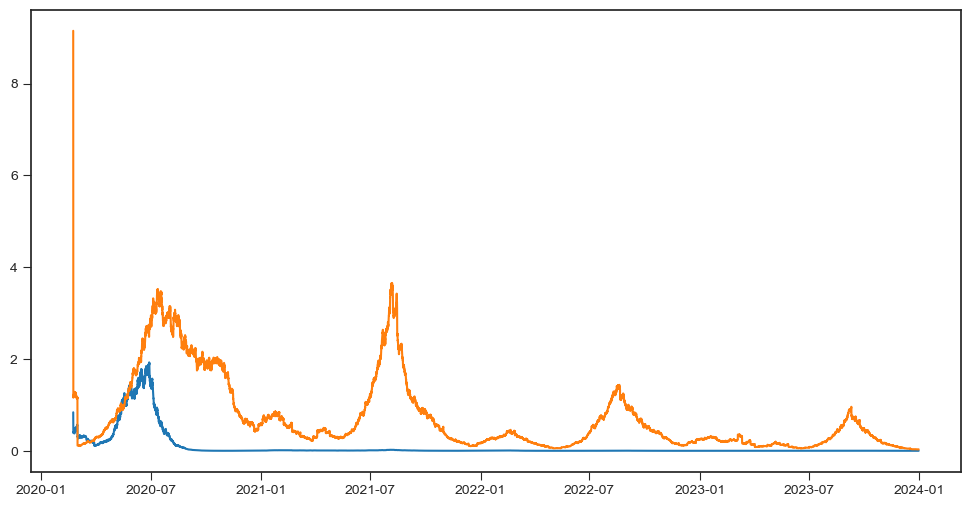

In [21]:
# Define start and end dates
start_date = pd.to_datetime(weekly_covid_df['date'].min())
end_date = pd.to_datetime(weekly_covid_df['date'].max())

# Generate 52 evenly spaced dates between start and end
dates = pd.date_range(start=start_date, end=end_date, periods=T*(m+1)+1)
plt.figure(figsize=(12,6))
plt.plot(dates, parameter_trajectories[-1,:])
plt.plot(dates, parameter_trajectories[-2,:])

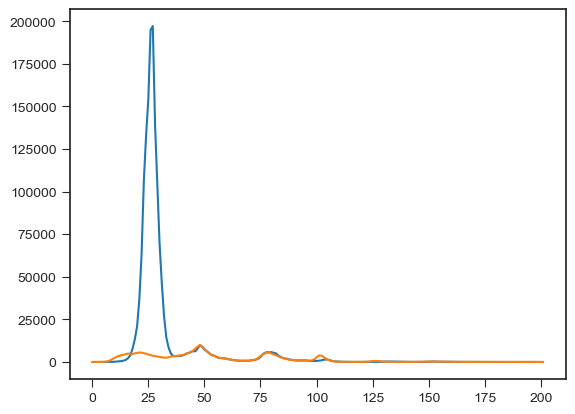

In [22]:
plt.plot(weekly_counts_trajectories[1,:])
plt.plot(YD)

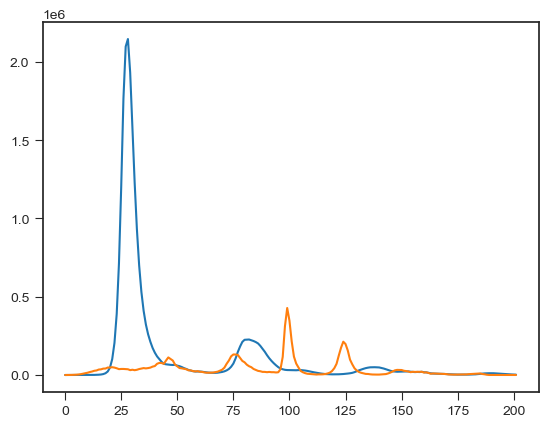

In [23]:
plt.plot(weekly_counts_trajectories[0,:])
plt.plot(YO)

Test MCMC with our BPF function

In [24]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, np.round(0.001 * N).astype(int)).rvs(num_particles)   #stats.uniform(0, 100).rvs(num_particles)
    O = np.ones(num_particles) * 4 
    U = stats.uniform(0, (E-O).astype(int)).rvs(num_particles)           #stats.uniform(0,5).rvs(num_particles)
    E = E - U - O    
    S = np.ones(num_particles) * N - E - U - O
    
    beta = stats.uniform(0,10).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(10,scale=100).rvs()
    psi_d = stats.gamma(10,scale=100).rvs() 
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]

In [25]:
def logprior(theta):
    alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d = theta
    if (alpha < 0 or alpha > 1 or 
        rho < 0 or rho > 1 or 
        nu < 0 or nu > 1 or 
        gamma < 0 or gamma > 1 or 
        sigma_b < 0 or sigma_m < 0 or 
        psi_o < 0 or psi_d < 0):
        return -np.inf
    else:
        logprior = stats.beta(2.3, 96.5).logpdf(alpha) 
        logprior += stats.beta(7.2, 0.8).logpdf(rho)
        logprior += stats.beta(6.9, 14.1).logpdf(nu)
        logprior += stats.beta(2.36, 9.44).logpdf(gamma)
        logprior += stats.invgamma(a=3.8, scale=0.6).logpdf(sigma_b)
        logprior += stats.invgamma(a=3.8, scale=0.6).logpdf(sigma_m)
        logprior += stats.gamma(10,scale=100).logpdf(psi_o)
        logprior += stats.gamma(10,scale=100).logpdf(psi_d)
        
    return logprior

In [28]:
theta_samples = []
loglikelihoods = []
weekly_trajectories = []
parameter_trajectories = []
acceptance_count = 0
AccRate = 0
num_iterations = 5000

T =  weeks - 1
m = 10
num_particles = 150

initial_conditions = set_IVC(N, num_particles)

sigma0 = np.diag([
    0.0000001,
    0.0000001,
    0.0000001,
    0.0000001,
    0.0000001,
    0.0000001,
    0.0000001,
    0.0000001   
])

In [29]:
# Loop to find viable starting parameters
while True:
    current_theta = set_param_priors()  # Sample initial parameters
    current_loglik, current_weekly, current_param = particle_filter(
        YO, YD, N, T, m, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood
    )
    # Check if the log-likelihood is valid
    if not np.isnan(current_loglik) and np.isfinite(current_loglik):  # Ensure log-likelihood is finite and not NaN
        break  # Exit the loop when valid parameters are found

print("Initial viable parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

loglikelihoods.append(current_loglik)
theta_samples.append(current_theta)
weekly_trajectories.append(current_weekly)
parameter_trajectories.append(current_param)

for i in range(num_iterations):
    proposed_theta = current_theta + stats.multivariate_normal(mean=np.zeros(8), cov=sigma0).rvs()
    if np.isinf(logprior(proposed_theta)):
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, current_weekly, current_param = particle_filter(YO, YD, N, T, m, num_particles, proposed_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)
        accept_prob = min(1, np.exp(proposed_loglik - current_loglik + logprior(proposed_theta) - logprior(current_theta)))
    
    if stats.uniform.rvs() < accept_prob:
            current_theta = proposed_theta
            current_loglik = proposed_loglik
            acceptance_count += 1
    
    loglikelihoods.append(current_loglik)
    theta_samples.append(current_theta) 
    weekly_trajectories.append(current_weekly)
    parameter_trajectories.append(current_param)
    
    AccRate = acceptance_count / (i + 1)
    
    if i % 100 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Unique Samples: ', np.unique(loglikelihoods).shape[0])

Initial viable parameters: [np.float64(0.015408366412157022), np.float64(0.9710314456217027), np.float64(0.32253767109355713), np.float64(0.06168475036967483), np.float64(0.14340900316603541), np.float64(0.8383119375570831), np.float64(953.5185936717186), np.float64(1590.097998529656)]
Initial log-likelihood: -100244.8786510497


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4250659356.py:26: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1, np.exp(proposed_loglik - current_loglik + logprior(proposed_theta) - logprior(current_theta)))


Iteration 0: Acceptance Rate = 100.00%
Unique Samples:  2


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:35: RuntimeWarning: overflow encountered in multiply
  X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:36: RuntimeWarning: overflow encountered in multiply
  X[1, :, t] = X[1, :, t - 1] + (X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:36: RuntimeWarning: invalid value encountered in subtract
  X[1, :, t] = X[1, :, t - 1] + (X[6, :, t-1] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_6203/4267127586.py:35: RuntimeWarning: invalid value encountered in add
  X[0, :, t] = X

Iteration 100: Acceptance Rate = 2.97%
Unique Samples:  4
Iteration 200: Acceptance Rate = 1.99%
Unique Samples:  5
Iteration 300: Acceptance Rate = 1.33%
Unique Samples:  5
Iteration 400: Acceptance Rate = 1.25%
Unique Samples:  6
Iteration 500: Acceptance Rate = 1.00%
Unique Samples:  6
Iteration 600: Acceptance Rate = 0.83%
Unique Samples:  6


KeyboardInterrupt: 

Element at index 148 is None.
Element at index 156 is None.
Element at index 157 is None.
Element at index 158 is None.
Element at index 159 is None.
Element at index 160 is None.
Element at index 233 is None.
Element at index 234 is None.
Element at index 321 is None.
Element at index 322 is None.
Element at index 323 is None.
Element at index 324 is None.


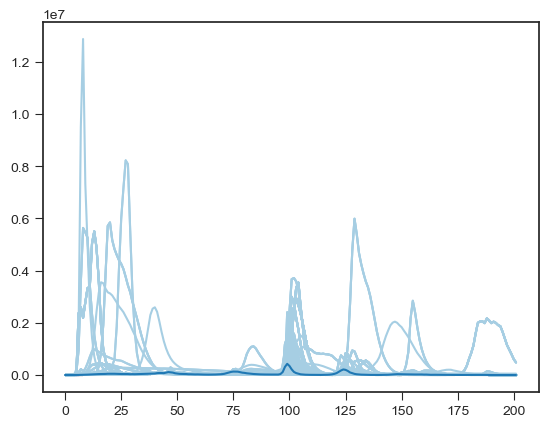

In [109]:
for i, t in enumerate(weekly_trajectories[:]):
    if t is None:
        print(f"Element at index {i} is None.")
    else:
        plt.plot(t[0,:], color=colors[0])
plt.plot(YO, color=colors[1])
plt.show()


Element at index 148 is None.
Element at index 156 is None.
Element at index 157 is None.
Element at index 158 is None.
Element at index 159 is None.
Element at index 160 is None.
Element at index 233 is None.
Element at index 234 is None.
Element at index 321 is None.
Element at index 322 is None.
Element at index 323 is None.
Element at index 324 is None.


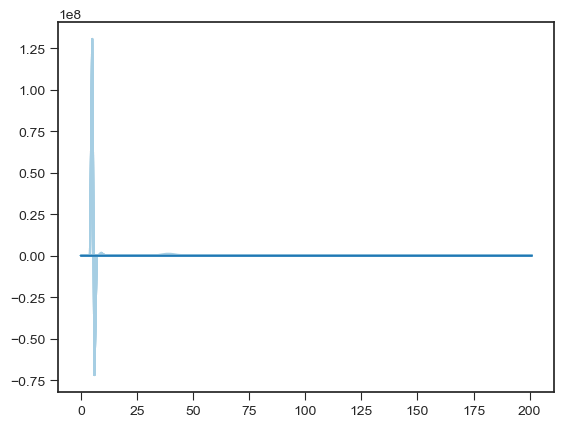

In [110]:
for i, t in enumerate(weekly_trajectories[:]):
    if t is None:
        print(f"Element at index {i} is None.")
    else:
        plt.plot(t[1,:], color=colors[0])
plt.plot(YD, color=colors[1])
plt.show()

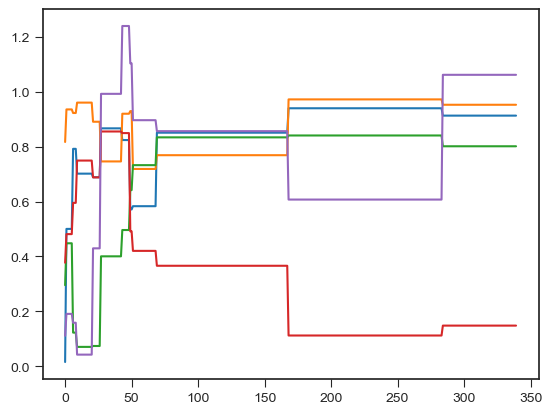

In [111]:
plt.plot(np.array(theta_samples[:])[:,:5])